In [ ]:
#Originally sequence markov transition probabilityes for 
#base letters and dimers were used as features.
#Later omitted to simplify the model.

In [1]:
import numpy as np
import pandas as pd
from Bio import SeqUtils
from Bio import SeqIO
import random
import pylab 
import scipy.stats as stats
from scipy.stats import kstest, norm
from scipy.stats import shapiro
import matplotlib.pyplot as plt 
import time
import seaborn as sns
from IPython.display import clear_output

In [6]:
#load data

df = pd.read_csv('../final file hopefully no errors.csv')
dfp = df.loc[df['Gen'] == 'ssRNA(+)']
dfn = df.loc[df['Gen'] == 'ssRNA(-)']

pndf = pd.concat([dfp, dfn]).reset_index(drop = True)
pndf['Len'] = [len(s) for s in pndf['Seq'].to_list()]

In [7]:
#merge tax with pndf

tax = pd.read_csv('id desc tax.csv')
tax = tax[['Id', 'Tax']].copy()

pndf = pd.merge(pndf,tax, on = 'Id', how = 'left')

FileNotFoundError: [Errno 2] File id desc tax.csv does not exist: 'id desc tax.csv'

In [8]:
#make transition matrix from query sequence
#starter code from https://stackoverflow.com/questions/46657221/generating-markov-transition-matrix-in-python

def transition_matrix(queryseq):
    
    transitions = []    
    for letter in queryseq:
        if letter == 'A':
            transitions.append(1)
        elif letter == 'T':
            transitions.append(2)
        elif letter == 'G':
            transitions.append(3)
        elif letter == 'C':
            transitions.append(4) 
    
    n = 5 #number of states
    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return np.array(M)[1:,1:]

#test:
t = 'GATAasdfCA'
m = transition_matrix(t)
for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))

0.00 0.50 0.00 0.50
1.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00


In [9]:
#column names

lets = 'ATGC'
tcols = []
for i in range(4):
    a = lets[i]
    for j in range(4):
        tcols.append((a + ' to ' + lets[j]))

In [10]:
#raw transition scores

l = []
for s in pndf['Seq'].tolist():
    m = transition_matrix(s)
    f = m.flatten()
    l.append(f)
    
tdfr = pd.DataFrame(l, columns = tcols)

In [11]:
tdfrp = tdfr.iloc[:2862,:]
tdfrn = tdfr.iloc[2862:, :].reset_index(drop = True)

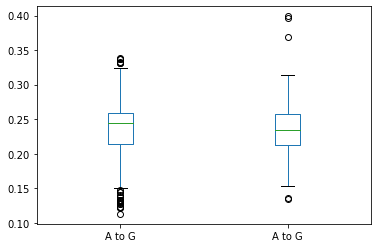

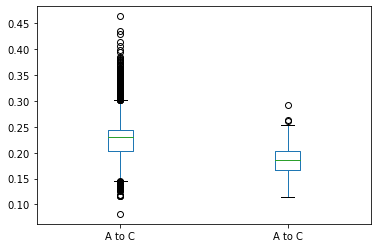

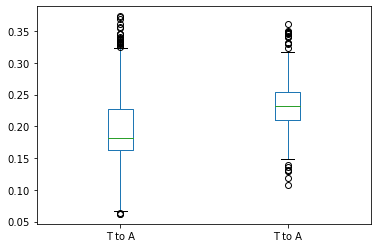

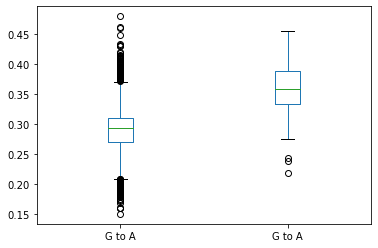

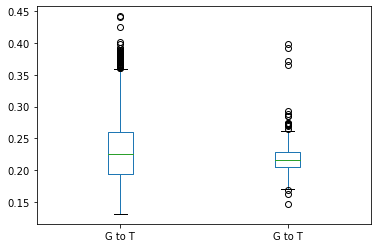

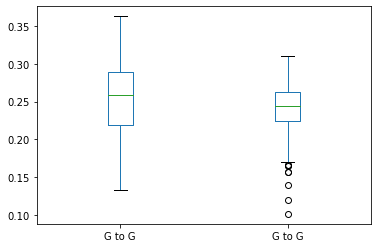

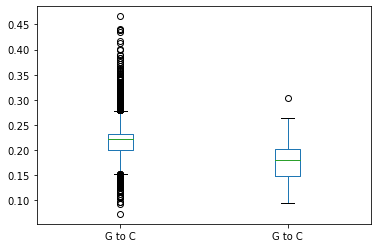

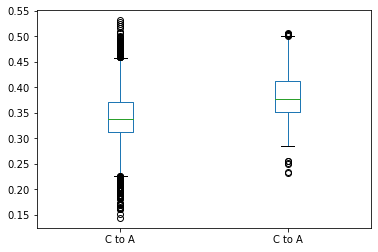

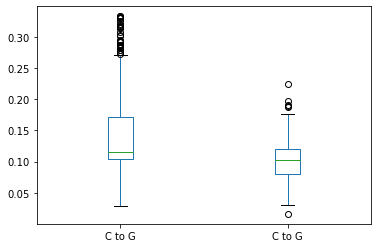

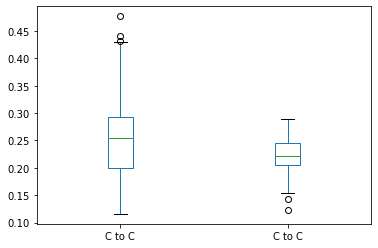

In [52]:
#kde plots
for i in range(16):
    pd.concat([tdfrp.iloc[:, i], tdfrn.iloc[:, i]], axis = 1).plot(kind='box')
    
#leaving out A to A, A to G, T to T, T to C, G to G, C to A, C to T, C to G

check data normalcy

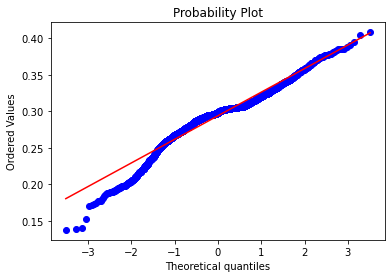

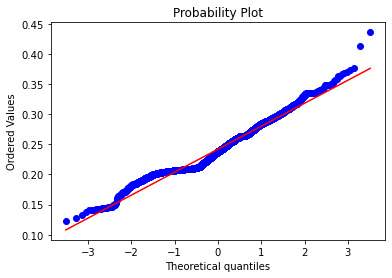

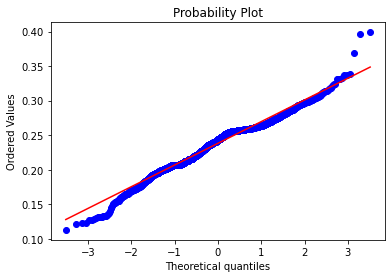

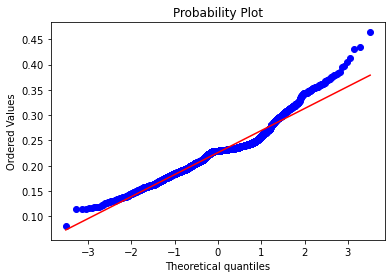

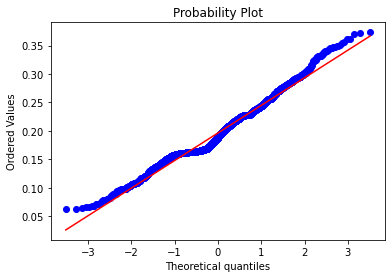

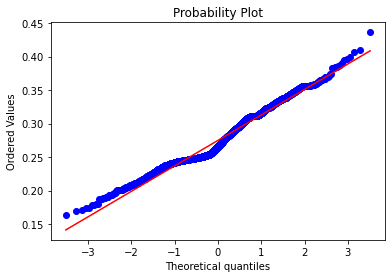

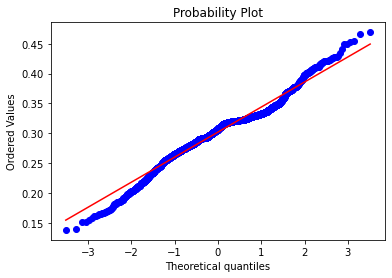

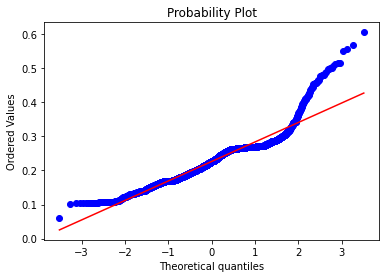

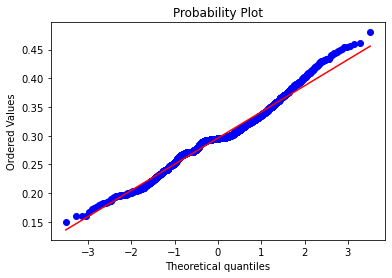

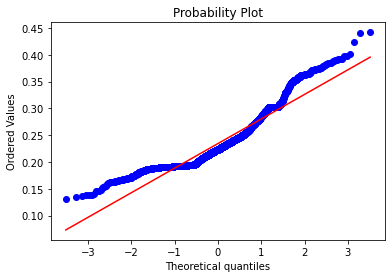

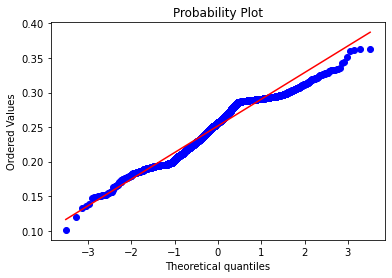

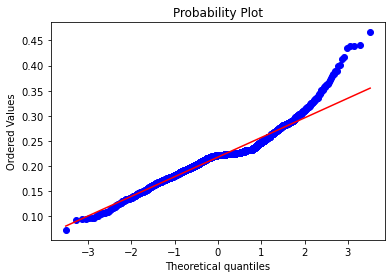

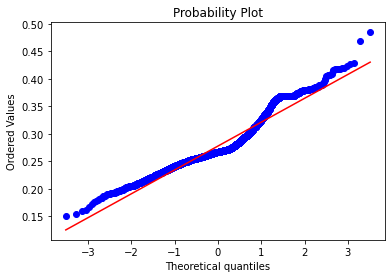

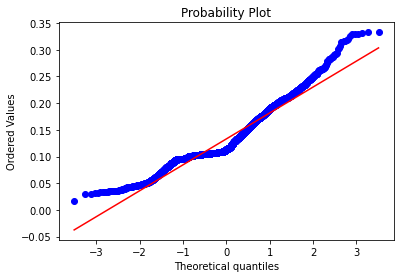

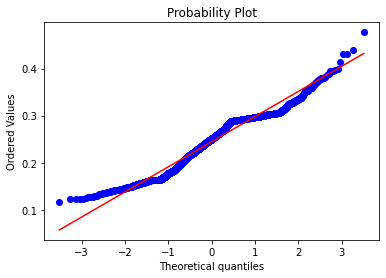

In [115]:
#qqplots
for i in range(16):
    x = tdfr.iloc[:,i].values
    stats.probplot(x, dist="norm", plot=pylab)
    pylab.show()

#tdfr looks fairly normal
#tdf doesn't

In [117]:
#Kolmogorov Smirnov test
for i in range(16):
    ks_statistic, p_value = kstest(tdfr.iloc[:,i], 'norm')
    print(ks_statistic, p_value)
    
#neither tdf or tdfr is not normally distributed

0.5693443461657656 0.0
0.5548296427859614 0.0
0.5525689910718361 0.0
0.5457335963840776 0.0
0.5278070861140267 0.0
0.5714299852231735 0.0
0.5639795429597823 0.0
0.5404705778263879 0.0
0.5684959474481922 0.0
0.5585590849226785 0.0
0.557325641103055 0.0
0.539497296351947 0.0
0.5680743978746081 0.0
0.5702833811929233 0.0
0.511678744633504 0.0
0.5486119127565645 0.0


In [119]:
#Shapiro Wilk test
for i in range(16):
    print(shapiro(tdfr.iloc[:,i]))

#nothing is normally distributed

(0.9464271664619446, 2.1685934145728225e-32)
(0.9646422863006592, 4.229698069728093e-27)
(0.9759968519210815, 1.28849145001464e-22)
(0.955074667930603, 4.345857534086067e-30)
(0.9750211834907532, 4.6640580605850893e-23)
(0.9674422144889832, 4.1445827513938654e-26)
(0.9704908132553101, 5.930927949425802e-25)
(0.9271527528762817, 1.2694605381108662e-36)
(0.9776471853256226, 7.722357563067876e-22)
(0.9023180603981018, 6.447794623897781e-41)
(0.9513493776321411, 4.050113593809015e-31)
(0.9428683519363403, 2.9711218484468267e-33)
(0.9774918556213379, 6.4982564742342305e-22)
(0.9303356409072876, 5.442789956991998e-36)
(0.9357430338859558, 7.321231938507492e-35)
(0.9596309065818787, 9.835628531341502e-29)


In [109]:
#how transition probabilites change as a function of length

len_score = []
for i in range(1,20000,500):
    rs = ''.join(random.choice('ATGC') for _ in range(i))
    
    m = transition_matrix(rs)
    for ms in m.flatten():
        len_score.append((len(rs), ms))

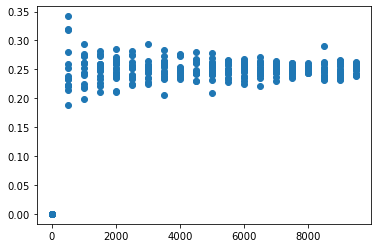

In [110]:
a = np.array(len_score)
plt.scatter(a[:,0],a[:,1])

#matrix scores can be unstable for very short random sequences 

In [128]:
#transition probabilities for real sequences

len_score = []

for s in pndf['Seq'].to_list():
    m = transition_matrix(s)
    temp = []
    for ms in m.flatten():
        temp.append((len(s), ms))
    len_score.append(temp)

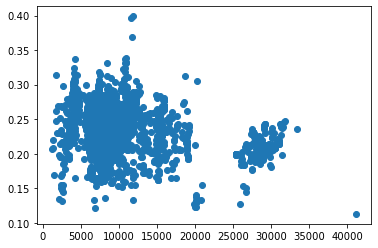

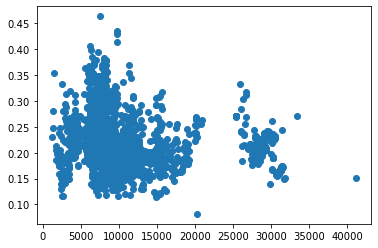

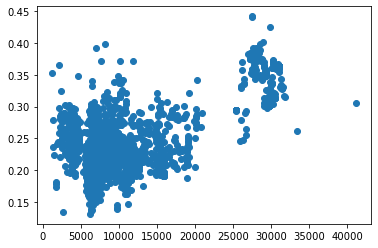

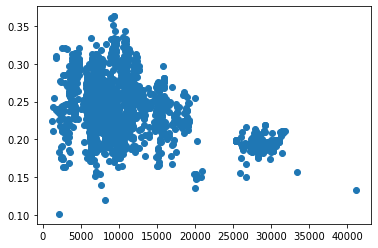

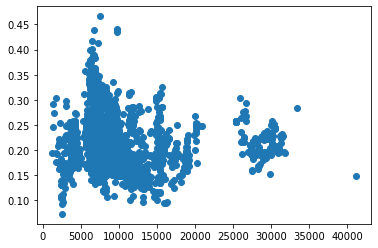

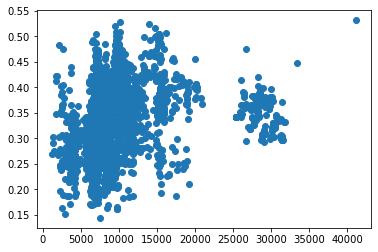

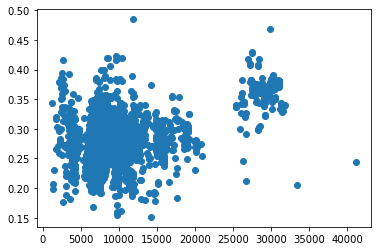

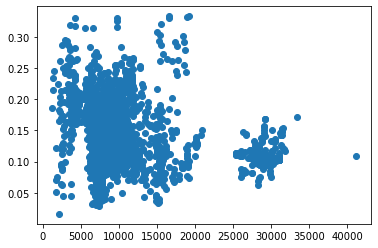

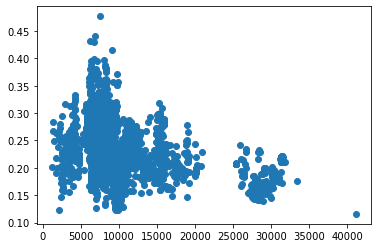

In [146]:
for i in range(16):
    temp = (lsdf.iloc[:,i].to_list())
    a = np.array(temp)
    plt.scatter(a[:,0],a[:,1])
    plt.show()
    
    
#transition probabilities are much more stable for sequences over 22k
#actually no. There are maybe just fewer data points

Length analysis (lol)

In [172]:
pndf.loc[pndf['Gen'] == 'ssRNA(+)'].loc[pndf['Len'] > 20000]

#355 +ssRNA sequences greater than 22k. 12% of sequences 
#367 above 20k. over 326 of them are coronaviruses. rest are tornidoviridae and mesnidoviridae
#no CoVs or tornidoviridaes between 15k and 20k. few mesnidoviridae

Id                                                Org MolTyp  \
0      MT291826.1    Severe acute respiratory syndrome coronavirus 2    RNA   
3     NC_032730.1                         Lucheng Rn rat coronavirus    RNA   
5      MN262644.1                                  Avian coronavirus    RNA   
6      KU973692.1  Severe acute respiratory syndrome-related coro...    RNA   
8      MH025762.1                           Porcine deltacoronavirus    RNA   
...           ...                                                ...    ...   
2834   AY351680.1                             SARS coronavirus ZMY 1    RNA   
2835   AY278554.2                           SARS coronavirus CUHK-W1    RNA   
2836   AY321118.1                               SARS coronavirus TWC    RNA   
2837   AY297028.1                              SARS coronavirus ZJ01    RNA   
2844   AF201929.1                    Murine hepatitis virus strain 2   mRNA   

       Topol                                                Des       Gen  \
0     linear  Severe acute respiratory syndrome coronavirus ...  ssRNA(+)   
3     linear  Lucheng Rn rat coronavirus isolate Lucheng-19,...  ssRNA(+)   
5     linear     Avian coronavirus strain CV10, complete genome  ssRNA(+)   
6     linear  UNVERIFIED: SARS-related coronavirus isolate F...  ssRNA(+)   
8     linear  Porcine deltacoronavirus strain CH/JXJGS01/P7,...  ssRNA(+)   
...      ...                                                ...       ...   
2834  linear            SARS coronavirus ZMY 1, complete genome  ssRNA(+)   
2835  linear          SARS coronavirus CUHK-W1, complete genome  ssRNA(+)   
2836  linear              SARS coronavirus TWC, complete genome  ssRNA(+)   
2837  linear             SARS coronavirus ZJ01, complete genome  ssRNA(+)   
2844  linear   Murine hepatitis virus strain 2, complete genome  ssRNA(+)   

                                                    Seq    Len  
0     TGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATT...  29807  
3     ACTTTTAGAGTATAATCTATTATACATAGATTTGCACTAACCCCTC...  28763  
5     ACTTAAGTGTGATATAAATATATATCATACACACTAGCCTTGTGCT...  27523  
6     ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...  29722  
8     ACATGGGGACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTA...  25438  
...                                                 ...    ...  
2834  TTATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...  29749  
2835  CTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTC...  29736  
2836  ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...  29725  
2837  CCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTT...  29715  
2844  ATAAGAGTGATTGGCGTCCGTACGTACCCTTTCTACTCTCAAACTC...  31276  

[367 rows x 8 columns]

In [197]:
#how many over 20k entries are coronaviruses

c = 0
for i,r in pndf.loc[pndf['Gen'] == 'ssRNA(+)'].loc[pndf['Len'] > 15000 ].loc[pndf['Len'] < 20000].iterrows():
    if 'corona' in r['Org'].lower() or 'cov' in r['Org'].lower():
        c+=1
    else:
        print(r['Org'], r['Tax'])
        print('\n')
print(c)

#loads

Areca palm velarivirus 1 ['Viruses', 'Riboviria', 'Closteroviridae', 'Velarivirus']


Porcine reproductive and respiratory syndrome virus ['Viruses', 'Riboviria', 'Nidovirales', 'Arnidovirineae', 'Arteriviridae', 'unclassified Arteriviridae']


Porcine reproductive and respiratory syndrome virus 2 ['Viruses', 'Riboviria', 'Nidovirales', 'Arnidovirineae', 'Arteriviridae', 'Variarterivirinae', 'Betaarterivirus', 'Ampobartevirus', 'Betaarterivirus suid 2']


Little cherry virus 1 ['Viruses', 'Riboviria', 'Closteroviridae', 'Velarivirus']


Little cherry virus 2 ['Viruses', 'Riboviria', 'Closteroviridae', 'Ampelovirus']


Bovine viral diarrhea virus 1 ['Viruses', 'Riboviria', 'Flaviviridae', 'Pestivirus']


Rodent arterivirus ['Viruses', 'Riboviria', 'Nidovirales', 'Arnidovirineae', 'Arteriviridae', 'unclassified Arteriviridae']


Phaseolus vulgaris endornavirus 3 ['Viruses', 'Riboviria', 'Endornaviridae', 'unclassified Endornaviridae']


Arracacha virus 1 ['Viruses', 'Riboviria', 'Closter

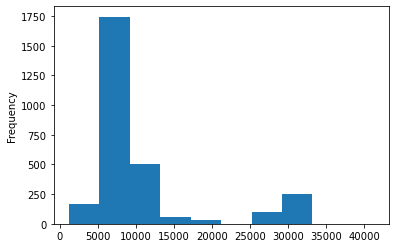

In [203]:
#look at length trend again

pndf.iloc[:2862, :]['Len'].plot(kind = 'hist')
pndf.iloc[2862:, :]['Len'].plot(kind = 'hist')

In [215]:
df['Gen'].unique()

array(['dsDNA', 'ssRNA(+)', 'ssRNA(-)', 'dsDNA-RT', 'ssRNA-RT',
       'ssDNA(+/-)', 'ssRNA', 'ssDNA(-)', 'dsRNA', 'ssDNA', 'ssDNA(+)',
       'ssRNA(+/-)', 'dsDNA; ssDNA'], dtype=object)

In [206]:
#length trend of other groups

#ssRNA(+/-)
t = df.loc[df['Gen'] == 'ssRNA(+/-)']
t['Len'] = [len(s) for s in t['Seq'].to_list()]
t.loc[t['Len'] > 5000]

#none greater than 7000

#ssRNA-RT
t = df.loc[df['Gen'] == 'ssRNA-RT']
t['Len'] = [len(s) for s in t['Seq'].to_list()]
t.loc[t['Len'] > 14000]

#none over 14k

#ssRNA
#viroids, none over 400

#dsRNA
#only 2 over 9k. none over 12k.

<ipython-input-206-2517287b1cfd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['Len'] = [len(s) for s in t['Seq'].to_list()]


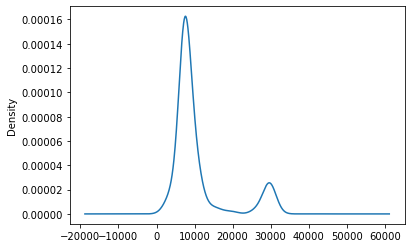

In [230]:
pndf.iloc[:2862, :]['Len'].plot(kind = 'kde')

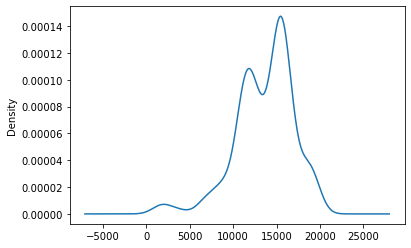

In [229]:
pndf.iloc[2862:, :]['Len'].plot(kind = 'kde')

In [238]:
pndf.iloc[2862:, :].loc[pndf.iloc[2862:, :]['Len'] < 2000]

#4 below 2000

Id                      Org  MolTyp   Topol  \
2980  NC_005218.1  Hantaan orthohantavirus  ss-RNA  linear   
2982  NC_005227.2     Tula orthohantavirus    cRNA  linear   
2993  NC_006433.1           Hantavirus Z10     RNA  linear   
3093  NC_029122.1              Tofla virus    cRNA  linear   

                                                    Des       Gen  \
2980                     Hantaan virus, complete genome  ssRNA(-)   
2982              Tula virus segment S, complete genome  ssRNA(-)   
2993  Hantavirus Z10 chromosome S segment, complete ...  ssRNA(-)   
3093  Tofla virus viral cRNA, complete genome, segme...  ssRNA(-)   

                                                    Seq   Len  \
2980  TAGTAGTAGACTCCCTAAAGAGCTACTAGAACAACGATGGCAACTA...  1696   
2982  TAGTAGTAGACTCCTTGAAAAGCTACTACTAAAACCGCTGGTATGA...  1831   
2993  TAGTAGTAGACTCCCTAAAGAGCTACTATAACAACGATGGCAACTA...  1701   
3093  TCTCAAAGACAAACGTGCCGCATACGCCCCACGTTTTCACAGACCT...  1699   

                                                    Tax  
2980  ['Viruses', 'Riboviria', 'Negarnaviricota', 'P...  
2982  ['Viruses', 'Riboviria', 'Negarnaviricota', 'P...  
2993  ['Viruses', 'Riboviria', 'Negarnaviricota', 'P...  
3093  ['Viruses', 'Riboviria', 'Negarnaviricota', 'P...

In [236]:
pndf.iloc[:2862, :].loc[pndf.iloc[:2862, :]['Len'] < 5000]

#169 below 5000

Id                                      Org MolTyp   Topol  \
62     LC523031.1  Nectarine stem pitting associated virus    RNA  linear   
183   NC_040434.1     Sclerotinia sclerotiorum mitovirus 2    RNA  linear   
187   NC_040543.1           Chenopodium quinoa mitovirus 1    RNA  linear   
194   NC_040559.1          Gigaspora margarita mitovirus 3    RNA  linear   
195   NC_040560.1          Gigaspora margarita mitovirus 4    RNA  linear   
...           ...                                      ...    ...     ...   
2685   DQ011234.1                Lisianthus necrosis virus    RNA  linear   
2732   AJ243370.1                      Pothos latent virus    RNA  linear   
2841   AF061869.1             Beet soil-borne mosaic virus    RNA  linear   
2855   AF227250.1                 Enterobacteria phage KU1    RNA  linear   
2860   AF059243.1                Enterobacteria phage NL95    RNA  linear   

                                                    Des       Gen  \
62    Nectarine stem pitting associated virus TAS17 ...  ssRNA(+)   
183   Sclerotinia sclerotiorum mitovirus 2, complete...  ssRNA(+)   
187   Chenopodium quinoa mitovirus 1 isolate Che1, c...  ssRNA(+)   
194   Gigaspora margarita mitovirus 3 isolate GmMV3-...  ssRNA(+)   
195   Gigaspora margarita mitovirus 4 isolate GmMV4-...  ssRNA(+)   
...                                                 ...       ...   
2685         Lisianthus necrosis virus, complete genome  ssRNA(+)   
2732  Pothos latent virus complete genome, pigeonpea...  ssRNA(+)   
2841  Beet soil-borne mosaic virus RNA2, complete ge...  ssRNA(+)   
2855           Enterobacteriophage KU1, complete genome  ssRNA(+)   
2860                Bacteriophage NL95, complete genome  ssRNA(+)   

                                                    Seq   Len  \
62    AGTAAAGTTTGACTGACTTTACAAGACTGGGGCTTCCTTGTTCCCG...  4991   
183   GGTTTTCGTGATCGTATCACGAATACCACGGAGACCCCCAGGGGTA...  2445   
187   TCCGAATCTCATTTTCGGAGTGGGTAGACGTCTTTCAGTCTACGCA...  2730   
194   ACGCAGAGTACATGGGGGGGGCACACCCGGCGTCGCAGCCGGGACA...  3387   
195   ACATGGGGGGGGCACCCCCGGTGATGAACCGGGCCAGAGGAGAATA...  3389   
...                                                 ...   ...   
2685  AGAAATTCCTCAGATTTCTCCCTGTGACCCGGGGTTATCGGTGAGT...  4764   
2732  GCCTAACCAGCTTGTTGAGAGTTGTGGAGCCATCCATATAGTTATT...  4354   
2841  GGATTCTAATTATTATCTCCATTGAATAGAATTTCACCAACTATTG...  4616   
2855  GGTTGGCGCCCCTTTCGGGGCGCTTGCTTTCTTCCTTGAAGGCGCT...  3486   
2860  GGGGGTAGGCCCCATAAGGGGCCTGCCTTCAACGCACTACAGAGGA...  4248   

                                                    Tax  
62    ['Viruses', 'Riboviria', 'Luteoviridae', 'Lute...  
183   ['Viruses', 'Riboviria', 'Narnaviridae', 'Mito...  
187   ['Viruses', 'Riboviria', 'Narnaviridae', 'Mito...  
194   ['Viruses', 'Riboviria', 'Narnaviridae', 'Mito...  
195   ['Viruses', 'Riboviria', 'Narnaviridae', 'Mito...  
...                                                 ...  
2685  ['Viruses', 'Riboviria', 'Tombusviridae', 'Pro...  
2732  ['Viruses', 'ssRNA viruses', 'ssRNA positive-s...  
2841  ['Viruses', 'Riboviria', 'Benyviridae', 'Benyv...  
2855  ['Viruses', 'Riboviria', 'Leviviridae', 'Leviv...  
2860  ['Viruses', 'Riboviria', 'Leviviridae', 'Allol...  

[169 rows x 9 columns]

In [ ]:
len(pndf.loc[pndf['Gen'] == 'ssRNA(-)'].loc[pndf['Len'] > 20000])

#9 over 19k, none over 20k

GC analysis

In [3]:
dfp['Len'] = [len(s) for s in dfp['Seq'].to_list()]
dfn['Len'] = [len(s) for s in dfn['Seq'].to_list()]

dfp = dfp.sort_values('Len').reset_index(drop = True)
dfn = dfn.sort_values('Len').reset_index(drop = True)

dfp['GC'] = [SeqUtils.GC(dfp.loc[i,'Seq']) for i in range(len(dfp))]
dfn['GC'] = [SeqUtils.GC(dfn.loc[i,'Seq']) for i in range(len(dfn))]

<ipython-input-3-f6b3f534691f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['Len'] = [len(s) for s in dfp['Seq'].to_list()]
<ipython-input-3-f6b3f534691f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['Len'] = [len(s) for s in dfn['Seq'].to_list()]


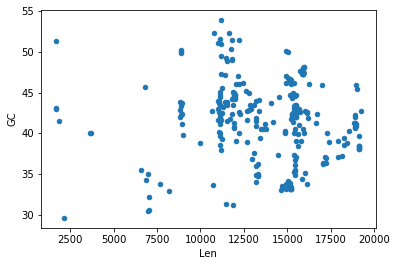

In [38]:
dfn.plot(x = 'Len', y = 'GC', kind='scatter')

In [43]:
dfp.loc[dfp['GC'] > 65 ] 

#the GC on these rubella viruses really stand out

Id                        Org  MolTyp   Topol  \
1573  NC_003347.1      Grapevine fleck virus     RNA  linear   
2115   MH745077.1  Rubella virus genotype 2B     RNA  linear   
2116  NC_001545.2              Rubella virus  ss-RNA  linear   
2117   MK780807.1  Rubella virus genotype 1A     RNA  linear   

                                                    Des       Gen  \
1573             Grapevine fleck virus, complete genome  ssRNA(+)   
2115  Rubella virus genotype 2B strain RVi/Pune.IND/...  ssRNA(+)   
2116                     Rubella virus, complete genome  ssRNA(+)   
2117  Rubella virus genotype 1A strain RVs/Oulu.FIN/...  ssRNA(+)   

                                                    Seq   Len         GC  
1573  GCACATTAGTACTGACCACCAGCCCGACTTTGACGCCACCCTGTCC...  7564  66.234796  
2115  CAATGGGAGCTACCGGACCTCGCTTAGGACTCCTATTCCCATGGAG...  9761  69.664993  
2116  CAATGGAAGCTATCGGACCTCGCTTAGGACTCCCATTCCCATGGAG...  9762  69.596394  
2117  CAATGGGAGCTATCGGACCTCGCTTAGGACTCCTATTCCCATGGAG...  9762  67.885679

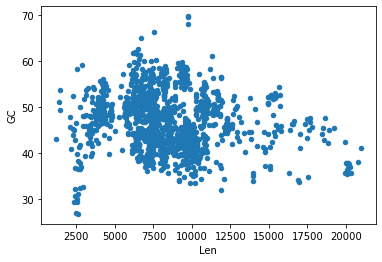

In [42]:
dfp.loc[dfp['Len'] < 25000].plot(x = 'Len', y = 'GC', kind='scatter')

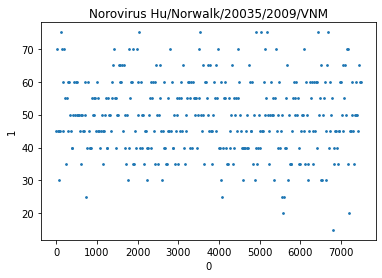

KeyboardInterrupt: 

In [97]:
#looking at distribution of gc contenct in a genome

def gc_plotter(seq, winsize):
    qgc = []
    for i in range(0, len(seq) - winsize + 1, winsize):
        query = seq[i: i + winsize]
        gc = SeqUtils.GC(query)
        qgc.append([i, gc])
        
    return qgc

for i,r in dfp.loc[dfp['Len'] > 5000].iterrows():
    pd.DataFrame(gc_plotter(r['Seq'],20)).plot(x = 0, y = 1, kind='scatter', s = 3)
    plt.title(r['Org'])
    plt.show()
    time.sleep(3)
    clear_output(wait=True)

One hot encoding length

In [ ]:
#2 splits   < 2k  | 22K
#2 splits   < 7k  | 22k
#2 splits   <13k  | 22k
#3 splits   < 2k | < 7k | 22k
#3 splits   < 2k | < 9k | 22k
#3 splits   < 2k | <13k | 22k
#4 splits   < 2k | < 7k | < 13k | 22k

In [42]:
pndf = pd.read_csv('pndf.csv')
#pndf['len < 2k'] = 0
pndf['2k - 13k'] = 0
pndf['13k - 22k'] = 0
pndf['len > 22k'] = 0

for i,r in pndf.iterrows():
    if 2000 <= r['Len'] < 13000:
        pndf.loc[i, '2k - 13k'] = 1
    elif 13000 <= r['Len'] < 22000:
        pndf.loc[i, '13k - 22k'] = 1
    elif r['Len'] >= 22000:
        pndf.loc[i, 'len > 22k'] = 1

Adding selected transition probabilities

In [53]:
pndf = pd.concat([pndf, tdfr], axis = 1)

In [55]:
pndf.to_csv('pndf lenc tp.csv', index = False)

In [51]:
tdfr.drop(columns = ['A to A', 'A to G', 'T to T', 'T to C', 'G to T', 'C to A', 'C to T', 'C to G'])

A to T    A to C    T to A    T to G    G to A    G to G    G to C  \
0     0.258271  0.226085  0.247700  0.270284  0.274949  0.186432  0.199419   
1     0.253898  0.194718  0.236100  0.259751  0.363171  0.201023  0.209207   
2     0.242755  0.191648  0.195514  0.287477  0.340286  0.220041  0.209407   
3     0.318418  0.193623  0.227678  0.285483  0.234668  0.200094  0.223404   
4     0.192803  0.228264  0.293188  0.321039  0.307478  0.306242  0.181397   
...        ...       ...       ...       ...       ...       ...       ...   
3140  0.274314  0.188487  0.237854  0.249456  0.350576  0.249187  0.180609   
3141  0.260348  0.213753  0.237406  0.274384  0.320701  0.246052  0.224232   
3142  0.254953  0.207580  0.219866  0.274631  0.329134  0.277406  0.201287   
3143  0.253448  0.208621  0.217918  0.275760  0.327891  0.278105  0.201285   
3144  0.253776  0.208459  0.217590  0.275417  0.327535  0.278031  0.201766   

        C to C  
0     0.161337  
1     0.145703  
2     0.148861  
3     0.173997  
4     0.262914  
...        ...  
3140  0.244934  
3141  0.238095  
3142  0.284735  
3143  0.284474  
3144  0.284963  

[3145 rows x 8 columns]